In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def deviation_matrix(X):
    p, n = X.shape # Get shape of matrix
    
    x_mean = np.sum(X, axis=1)/n # Find mean of each row
    x_mean_M = np.tile(x_mean, (n, 1)).T # Repeat mean values as columns in a p x n matrix
    Y = X - x_mean_M
    
    W = []
    # Generate W array (which is 3D) of size (n, p, p), order of indices (k, i, j)
    for k in range(n):
        w = Y[:,k]
        W.append(np.outer(w, w))
    W_mean = np.sum(W, axis=0)/n
    
    return W

In [3]:
def shrinkage_cov_matrix(X, T):
    p, n = X.shape # Get shape of matrix
    
    # For sample covariance
    W = deviation_matrix(X)
    W_mean = np.sum(W, axis=0)/n
    
    # Emperically estimated covariance matrix
    S = n / (n-1) * W_mean
    
    W_mean_matrix = np.tile(W_mean, (n, 1, 1))
    # Compute variance of elements of the covariance matrix
    Var = n / (n-1)**3 * np.sum((W-W_mean_matrix)**2, axis=0)
    
    # For target covariance
    V = deviation_matrix(T)
    V_mean = np.sum(V, axis=0)/n
    
    # Compute estimated shrinkage intensity parameter lambda
    lmbda_est = np.sum(Var) / np.sum((T-S)**2)
    
    # Compute shrinkage covariance matrix
    C_shrinkage = lmbda_est*T + (1-lmbda_est)*S
    
    return C_shrinkage, S, lmbda_est

In [11]:
def get_lmbda_MSE(n):
    # parameters
    p = 18 # nr of random variables
    mean = 0
    sigma = 1.1

    T = np.identity(p) # Target matrix
    C_true = sigma**2 * np.identity(p) # True covariance
    
    lmbdas_est = []
    evals_MC_sum = np.zeros(p)
    evals_MCS_sum = np.zeros(p)
    MSE_MC_sum = 0
    MSE_MCS_sum = 0
    
    m = 100 # nr of simulations
    for _ in range(m):
        # Generate random data
        X = np.random.normal(mean, sigma, size=(p, n))
        # Get shrinkage covariance matrice and properties
        C_shrinkage, S, lmbda_est = shrinkage_cov_matrix(X, T)
        
        # Compute eigenvalues
        evals_MC = np.linalg.eigvalsh(S)
        evals_MCS = np.linalg.eigvalsh(C_shrinkage)
        
        # Compute MSE using the Frobenius matrix norm
        MSE_MC = np.trace((S-C_true)@(S-C_true).T)
        MSE_MCS = np.trace((C_shrinkage-C_true)@(C_shrinkage-C_true).T)
        
        lmbdas_est.append(lmbda_est)
        evals_MC_sum += evals_MC
        evals_MCS_sum += evals_MCS
        MSE_MC_sum += MSE_MC
        MSE_MCS_sum += MSE_MCS

    lmbda_est = np.average(lmbdas_est)
    lmbda_est_se = np.std(lmbdas_est)
    
    evals_MC = evals_MC_sum / m
    evals_MCS = evals_MCS_sum / m
    evals_T = np.linalg.eigvalsh(T)
    evals_true = np.linalg.eigvalsh(C_true)
    
    MSE_MC = MSE_MC_sum / m
    MSE_MCS = MSE_MCS_sum / m
    MSE_T = np.trace((T-C_true)@(T-C_true).T)
    
    return lmbda_est, lmbda_est_se, evals_MC, evals_MCS, evals_T, evals_true, MSE_MC, MSE_MCS, MSE_T

In [10]:
lmbda_est, lmbda_est_se, _, _, _, _, MSE_MC, MSE_MCS, MSE_T = get_lmbda_MSE(4000)
print(f"Optimal value for shrinkage intensity: {lmbda_est}")
print(f"Standard deviation: {lmbda_est_se}")
print(f"MSE for MC: {MSE_MC}")
print(f"MSE for MC+S: {MSE_MCS}")
print(f"MSE for Target: {MSE_T}")

Optimal value for shrinkage intensity: 0.13641202052051526
Standard deviation: 0.005906890773362246
MSE for MC: 0.1255857485839583
MSE for MC+S: 0.1086008465169961
MSE for Target: 0.7938000000000013


In [6]:
# parameters
p = 18 # nr of random variables
n = 40
mean = 0
sigma = 1.1

T = np.identity(p) # Target matrix
C_true = sigma**2 * np.identity(p) # True covariance

# Generate random data
X = np.random.normal(mean, sigma, size=(p, n))
# Get shrinkage covariance matrice and properties
C_shrinkage, S, lmbda_est = shrinkage_cov_matrix(X, T)

In [7]:
# Compute eigenvalues
evals_true = np.linalg.eigvalsh(C_true)
evals_sample = np.linalg.eigvalsh(S)
evals_shrinkage = np.linalg.eigvalsh(C_shrinkage)
evals_target = np.linalg.eigvalsh(T)

<IPython.core.display.Javascript object>


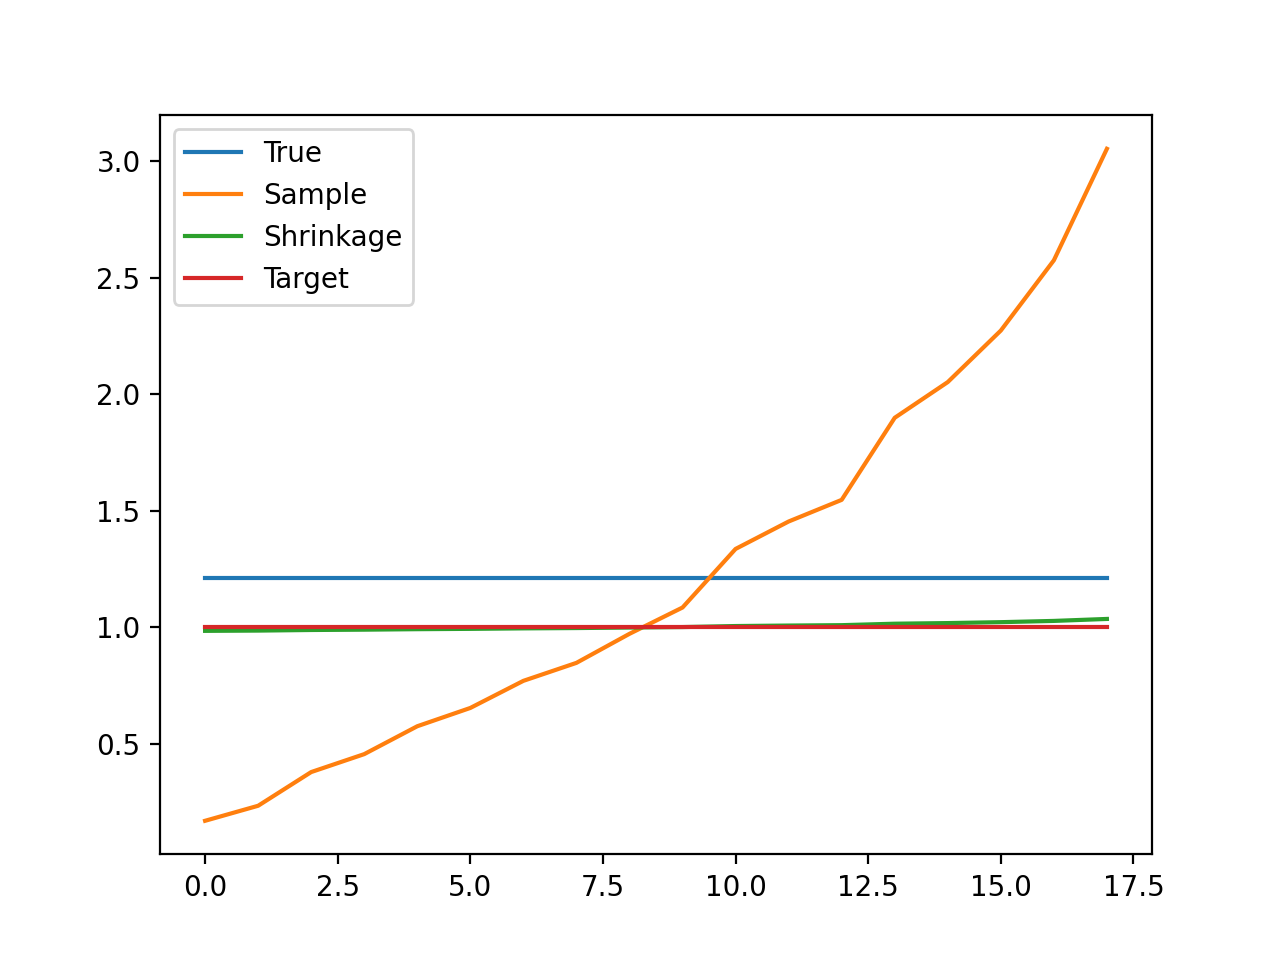

In [8]:
plt.plot(evals_true, label="True")
plt.plot(evals_sample, label="Sample")
plt.plot(evals_shrinkage, label="Shrinkage")
plt.plot(evals_target, label="Target")
plt.legend()